This is a follow-up of the notebook unknown_municipalities_varying_test_size.ipynb
To evaluate the effect of different pre-processing techniques on the performance to predict vote results for previously unknown municipalities, we explored different methods to preprocess topics. This included applying a cut-off to retain
only values above specified thresholds (0, 10, 20, 30, 40) and selecting the top n topics with the highest
shares, setting all others to zero (where n was equal to 1, 2, 5, 10, or 56, representing all topics).

In [5]:
import random
import math

import pandas as pd
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error

import sys
sys.path.append("/home/carlo/ask-volk/src")
from utils import pre_process_topics

In [6]:
n = 200

min_year = 1981

random.seed(42)

In [7]:
nv = pd.read_csv("../data/intermediate/national_votes.csv")
topics = pd.read_csv("../data/processed/summary_topics.csv")
controls = pd.read_parquet("../data/intermediate/controls/socioeconomic_0.parquet")

nv["id"] /= 10
nv = nv[nv["id"] >= topics["id"].min()]
nv = nv[nv["id"] <= topics["id"].max()]
nv["jaStimmenInProzent"] /= 100

In [8]:
nv.dropna(subset='jaStimmenInProzent',inplace=True)

In [9]:
# Prepare controls
controls.dropna(inplace=True)
controls["YEAR"] = controls["YEAR"].astype(int)
controls = controls[controls["YEAR"] >= min_year]
controls

,CAN_NAME,DIS_ID,DIS_NAME,MUN_ID,MUN_NAME,CAN_ID,YEAR,VALUE,DATA
0,ZH,101.0,Affoltern,1.0,Aeugst am Albis,1.0,1981,DATA_Auswanderung_Frau_Ausland,1.0
1,ZH,101.0,Affoltern,1.0,Aeugst am Albis,1.0,1981,DATA_Auswanderung_Frau_Schweiz,2.0
2,ZH,101.0,Affoltern,1.0,Aeugst am Albis,1.0,1981,DATA_Auswanderung_Frau_Staatsangehörigkeit (Ka...,3.0
3,ZH,101.0,Affoltern,1.0,Aeugst am Albis,1.0,1981,DATA_Auswanderung_Mann_Ausland,0.0
4,ZH,101.0,Affoltern,1.0,Aeugst am Albis,1.0,1981,DATA_Auswanderung_Mann_Schweiz,4.0
...,...,...,...,...,...,...,...,...,...
9679819,JU,2603.0,Porrentruy,6811.0,Damphreux-Lugnez,26.0,2022,DATA_Änderung des Bevölkerungstyps_Frau_Schweiz,0.0
9679820,JU,2603.0,Porrentruy,6811.0,Damphreux-Lugnez,26.0,2022,DATA_Änderung des Bevölkerungstyps_Frau_Staats...,0.0
9679821,JU,2603.0,Porrentruy,6811.0,Damphreux-Lugnez,26.0,2022,DATA_Änderung des Bevölkerungstyps_Mann_Ausland,0.0
9679822,JU,2603.0,Porrentruy,6811.0,Damphreux-Lugnez,26.0,2022,DATA_Änderung des Bevölkerungstyps_Mann_Schweiz,0.0


In [10]:
index = ["YEAR", "MUN_ID"] if "MUN_ID" in controls.columns else ["YEAR"]
controls = controls.pivot(index=index, columns="VALUE", values="DATA")

In [11]:
nv.dropna(inplace=True)
nv["votedate"] = pd.DatetimeIndex(nv["votedate"])
nv["year"] = nv["votedate"].dt.year
nv["month"] = nv["votedate"].dt.month / 12

In [12]:
left_on = ["year", "mun_id"] if "MUN_ID" in index else ["year"]
nv_with_stats = pd.merge(nv, controls, left_on=left_on, right_index=True)

In [13]:
# Drop the columns we don't need...
nv_with_stats.drop(
    columns=[
        "Unnamed: 0",
        "name",
        "canton_name",
        "mun_name",
        "geoLevelParentnummer",
        "gebietAusgezaehlt",
        "jaStimmenAbsolut",
        "neinStimmenAbsolut",
        "stimmbeteiligungInProzent",
        "eingelegteStimmzettel",
        "anzahlStimmberechtigte",
        "gueltigeStimmen",
        "votedate",
    ]
, inplace=True)
# ... and prepare for XGBoost
nv_with_stats.dropna(inplace=True)
nv_with_stats["year"] -= nv_with_stats["year"].min()
nv_with_stats["mun_id"] = nv_with_stats["mun_id"].astype("category")
nv_with_stats["canton_id"] = nv_with_stats["canton_id"].astype("category")

In [17]:
# including topics and stats
parameters= {'cutoff': [0, 10, 20, 30, 40], 'highest': [1, 2, 5, 10, 56]}
seeds = [17, 23, 32, 42, 47]
muns = nv["mun_id"].unique()
results = pd.DataFrame(columns=['method', 'parameter', 'seed', 'r2', 'rmse'])
size = 0.2
for method in parameters.keys():
    for parameter in parameters[method]:
        if method == 'cutoff':
            preprocessed_topics = pre_process_topics(topics, mode=method, threshold=parameter)
        elif method == 'highest':
            preprocessed_topics = pre_process_topics(topics, mode=method, number=parameter)
        nv_with_stats_topics = nv_with_stats.merge(preprocessed_topics, left_on="id", right_on="id")
        for seed in seeds:
            random.seed(seed)
            sample = random.sample(muns.tolist(), math.floor(size * len(muns)))
            Xy_train = nv_with_stats_topics[~nv_with_stats_topics["mun_id"].isin(sample)]
            Xy_test = nv_with_stats_topics[nv_with_stats_topics["mun_id"].isin(sample)]
            X_train = Xy_train.drop(columns='jaStimmenInProzent')
            X_test = Xy_test.drop(columns='jaStimmenInProzent')
            y_train = Xy_train['jaStimmenInProzent']
            y_test = Xy_test['jaStimmenInProzent']
            dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
            dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
            bst = xgb.train({"eta": 0.01}, dtrain, 1000)
            y_pred = bst.predict(dtest)
            r2 = r2_score(y_test, y_pred)
            rmse = root_mean_squared_error(y_test, y_pred)
            print(f'results for method {method}, parameter {parameter}, seed {seed}: R2: {r2}, rmse: {rmse}')
            results_dict = {'method': method, 'parameter': parameter,'seed': seed, 'r2': r2, 'rmse': rmse}
            results = pd.concat([results, pd.DataFrame([results_dict])], ignore_index=True)

results for method cutoff, parameter 0, seed 17: R2: 0.768396733151926, rmse: 0.09652748183206614


/tmp/ipykernel_64068/1465556863.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([results_dict])], ignore_index=True)


results for method cutoff, parameter 0, seed 23: R2: 0.7552340572914731, rmse: 0.10073393060881639
results for method cutoff, parameter 0, seed 32: R2: 0.7673108751427442, rmse: 0.09731339840918246
results for method cutoff, parameter 0, seed 42: R2: 0.764724920218313, rmse: 0.09774672252924697
results for method cutoff, parameter 0, seed 47: R2: 0.7693619948470037, rmse: 0.09698801363447937
results for method cutoff, parameter 10, seed 17: R2: 0.6479252187361577, rmse: 0.11901346380720482
results for method cutoff, parameter 10, seed 23: R2: 0.6397076552125527, rmse: 0.12221592614756459
results for method cutoff, parameter 10, seed 32: R2: 0.6537286824745698, rmse: 0.11871151731601408
results for method cutoff, parameter 10, seed 42: R2: 0.6530917093172404, rmse: 0.11869203587351902
results for method cutoff, parameter 10, seed 47: R2: 0.6542826297426672, rmse: 0.11874442496826522
results for method cutoff, parameter 20, seed 17: R2: 0.6110845171621007, rmse: 0.12508529369490456
resul

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate the data by method and parameter, averaging over seeds
aggregated = results.groupby(['method', 'parameter']).agg({'r2': 'mean', 'rmse': 'mean'}).reset_index()

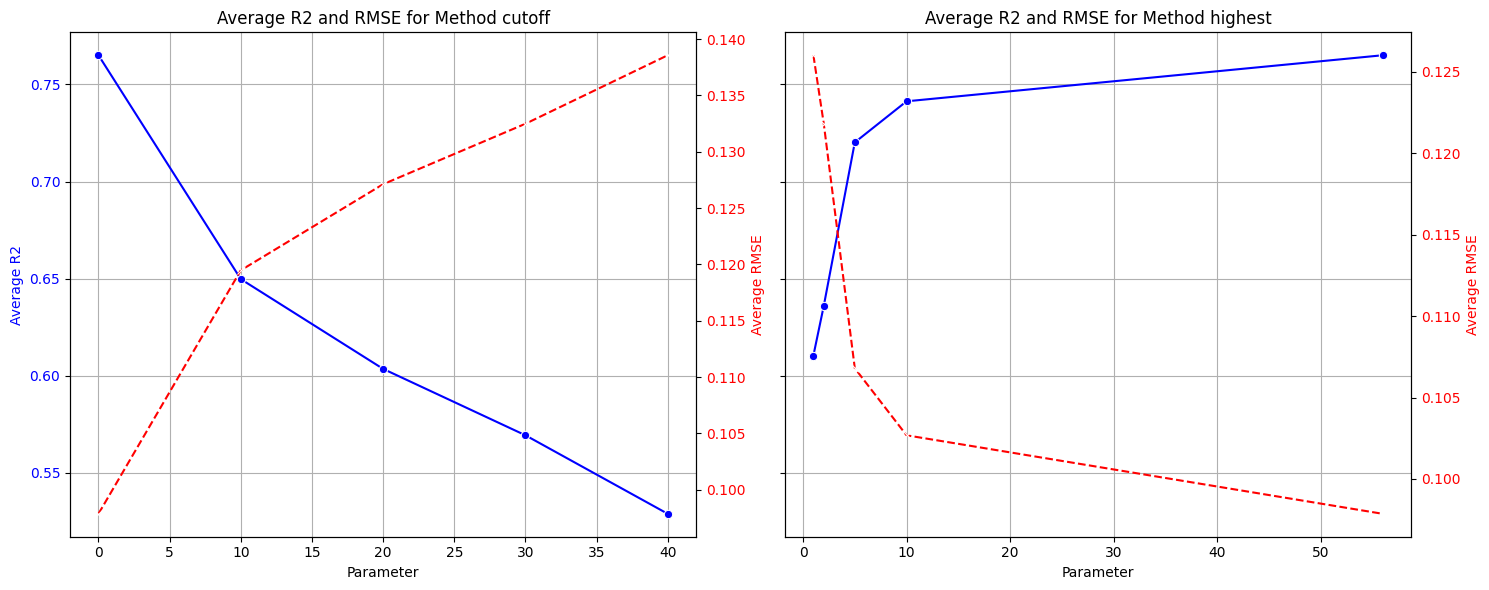

In [29]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot r2 and rmse for each method separately
for method, ax in zip(aggregated['method'].unique(), axes):
    method_data = aggregated[aggregated['method'] == method]
    
    # Plot r2
    sns.lineplot(data=method_data, x='parameter', y='r2', ax=ax, marker='o', color='blue')
    ax.set_title(f'Average R2 and RMSE for Method {method}')
    ax.set_xlabel('Parameter')
    ax.set_ylabel('Average R2', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.grid(True)
    
    # Create a secondary y-axis for rmse
    ax2 = ax.twinx()
    sns.lineplot(data=method_data, x='parameter', y='rmse', ax=ax2, marker='x', color='red', linestyle='dashed')
    ax2.set_ylabel('Average RMSE', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
plt.tight_layout()
plt.savefig('../plots/varying_preprocessing.png')
plt.show()